In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from torch import nn

# Test Model

### Get Test Data and Model

In [2]:
# MAKE SURE THESE ARE UP TO DATE WITH THE CLASS DEFINED IN model_training.ipynb

class RelevanceDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = torch.tensor(X_data.reset_index(drop=True).embeddings)
        self.y_data = torch.tensor(y_data.reset_index(drop=True).relevance).long()

    def __getitem__(self, item):
        return self.X_data[item], self.y_data[item]

    def __len__(self):
        return len(self.X_data)


class Classifier(nn.Module):
    def __init__(self, num_features, hidden_layer_size, kernel_size, pool_size, num_class):
        super(Classifier, self).__init__()

        self.conv1 = nn.Conv1d(num_features, hidden_layer_size, kernel_size)
        self.conv2 = nn.Conv1d(hidden_layer_size, hidden_layer_size, kernel_size)
        self.fc1 = nn.Linear(48384, 48384)
        self.fc_out = nn.Linear(48384, num_class)

        self.pool = nn.MaxPool1d(pool_size)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.pool(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc_out(x)

        return x

EPOCHS = 300
BATCH_SIZE = 16
LEARNING_RATE = 0.0007

KERNEL_SIZE = 5
POOL_SIZE = 2
HIDDEN_LAYER_SIZE = 256

NUM_FEATURES = 400
NUM_CLASSES = 4

In [3]:
test_dataset = torch.load('data/test_dataset.pt')
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

model = Classifier(num_features=NUM_FEATURES, hidden_layer_size=HIDDEN_LAYER_SIZE, kernel_size=KERNEL_SIZE, num_class=NUM_CLASSES, pool_size=POOL_SIZE)
model.load_state_dict(torch.load('models/model_v1.pt'))

<All keys matched successfully>

#### Conduct Test

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5]:
y_pred_list = []

with torch.no_grad():
    model.eval()

    for X_batch, _, in test_loader:
        X_batch = X_batch.to(device)

        y_test_pred = model(X_batch)

        _, y_pred_tags = torch.max(y_test_pred, dim=1)
        y_pred_list.append((y_pred_tags.cpu().numpy()))

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

#### Confusion Matrix and Classifcation Report

In [6]:
y_test = [d[1].item() for d in test_dataset]
y_test

[0,
 1,
 2,
 3,
 3,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 3,
 0,
 3,
 0,
 0,
 0,
 2,
 0,
 3,
 0,
 0,
 0,
 0,
 1,
 3,
 1,
 0,
 1,
 2,
 3,
 3,
 1,
 0,
 0,
 0,
 1,
 2,
 3,
 1,
 1,
 2,
 1,
 0,
 0,
 3,
 2,
 1,
 1,
 0,
 0,
 2,
 1,
 0,
 1,
 3,
 3,
 3,
 0,
 2,
 0]

<Axes: >

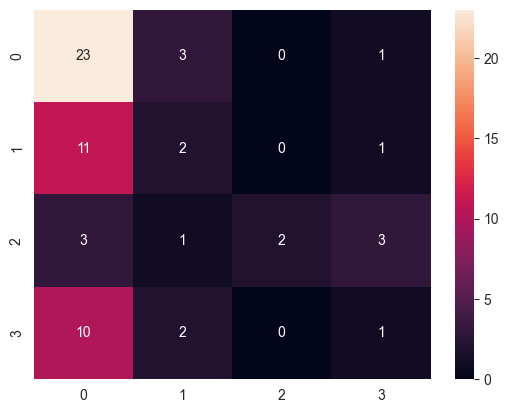

In [7]:
cm_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list))

sns.heatmap(cm_df, annot=True)

In [8]:
print(classification_report(y_test, y_pred_list, zero_division=0))

              precision    recall  f1-score   support

           0       0.49      0.85      0.62        27
           1       0.25      0.14      0.18        14
           2       1.00      0.22      0.36         9
           3       0.17      0.08      0.11        13

    accuracy                           0.44        63
   macro avg       0.48      0.32      0.32        63
weighted avg       0.44      0.44      0.38        63

